In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!unzip colab.zip

Archive:  colab.zip
replace __init__.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
!pip install lightning==2.0.1 lpips==0.1.4 tensorboardX==2.6 tqdm==4.64.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.5/553.5 kB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [4]:
import os
from bs4 import BeautifulSoup
import shutil
import requests
import threading
import argparse
import lightning.pytorch as pl
from PIL import Image
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from src.model import Autoencoder
from src.data import ReflectionDataModule
from src.utils import GenerateCallback
from src.utils import get_train_images

In [5]:
epochs = 100
latent_dim = 64
learning_rate = 0.0005
split_dir = "splits"
data_dir = "data"
batch_size = 32
out_dir = "out"

In [6]:
def download_data_from_google_drive(url, data_dir):
    '''
    Downloads the dataset from the specified Google Drive folder URL in the constructor to the 
    specified data directory.
    '''

    soup = BeautifulSoup(requests.get(url).content, 'html.parser')
    flip_entries = soup.find_all(class_='flip-entry')
    threads = []
    for entry in flip_entries:
        file_id = entry.get('id').replace('entry-', '')
        title = entry.find(
            class_='flip-entry-title').encode_contents().decode()
        file_dir = os.path.join(data_dir, title)
        thread = threading.Thread(
            target=download_file, args=(file_id, file_dir))
        thread.start()
        threads.append(thread)

    # Wait for all threads to finish
    for thread in threads:
        thread.join()

def download_file(file_id, file_dir):
    r = requests.get(
        f'https://drive.google.com/uc?export=download&id={file_id}', stream=True)
    with open(file_dir, 'wb') as f:
        shutil.copyfileobj(r.raw, f)

# Create data dir
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
# Download data
if not os.listdir(data_dir):
    print(f"Downloading data to {data_dir}")
    download_data_from_google_drive(
        url='https://drive.google.com/embeddedfolderview?id=1kNnCS58dCcHsZVS2dDyDmxugcxLSuPF5#list',
        data_dir=data_dir
    )
# Create out dir
if not os.path.exists(data_dir):
    os.makedirs(out_dir)

In [9]:
ckpt_path = "/content/drive/MyDrive/epoch.ckpt"

In [10]:
module = Autoencoder(latent_dim, learning_rate)

datamodule = ReflectionDataModule(split_dir, data_dir, batch_size)

callbacks = [
    ModelCheckpoint(dirpath=out_dir),
    ModelCheckpoint(monitor="val/loss", dirpath=out_dir, filename="best"),
    GenerateCallback(get_train_images(data_dir, 4), every_n_epochs=10),
    LearningRateMonitor("epoch")]

trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator="gpu",
    devices=[0],
    callbacks=callbacks,
    default_root_dir=out_dir,
    detect_anomaly=True)

Building samples for logging:   0%|          | 0/4 [00:00<?, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [11]:
import torch
torch.load(ckpt_path)

{'epoch': 999,
 'global_step': 3000,
 'pytorch-lightning_version': '2.0.1',
 'state_dict': OrderedDict([('encoder.net.0.weight',
               tensor([[[[ 0.1245,  0.0963,  0.0607],
                         [-0.1828,  0.0679,  0.1381],
                         [ 0.0077, -0.0662,  0.0090]],
               
                        [[ 0.1897,  0.1340,  0.0773],
                         [-0.1389, -0.0964,  0.1890],
                         [-0.1105,  0.0360, -0.0146]],
               
                        [[ 0.0642, -0.1363,  0.1443],
                         [-0.1075,  0.0626, -0.1634],
                         [-0.1171,  0.0617, -0.0224]]],
               
               
                       [[[ 0.0378,  0.0911, -0.1297],
                         [-0.0026, -0.0189,  0.0266],
                         [-0.1634,  0.1356,  0.0902]],
               
                        [[-0.0089, -0.0286, -0.0162],
                         [-0.1240, -0.1038, -0.1827],
                         [-0.0

In [12]:
module.load_from_checkpoint(ckpt_path)

Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GELU(approximate='none')
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): GELU(approximate='none')
      (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): GELU(approximate='none')
      (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): GELU(approximate='none')
      (10): Flatten(start_dim=1, end_dim=-1)
      (11): Linear(in_features=100352, out_features=64, bias=True)
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=64, out_features=100352, bias=True)
      (1): GELU(approximate='none')
    )
    (net): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), 

In [13]:
img_path = '/content/data/2007_003506-input.png'

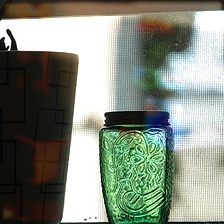

In [14]:
Image.open(img_path)

In [15]:
from PIL import Image
from torchvision.transforms import transforms, ToPILImage

img = Image.open(img_path)

transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])

inp = transform(img).unsqueeze(0)

In [16]:
outp = module(inp)

In [17]:
outp[0]

tensor([[[-0.1382, -0.1462, -0.1376,  ..., -0.1449, -0.1394, -0.1513],
         [-0.1436, -0.1663, -0.1429,  ..., -0.1617, -0.1448, -0.1409],
         [-0.1372, -0.1478, -0.1367,  ..., -0.1467, -0.1390, -0.1513],
         ...,
         [-0.1431, -0.1674, -0.1425,  ..., -0.1614, -0.1428, -0.1404],
         [-0.1383, -0.1474, -0.1378,  ..., -0.1482, -0.1392, -0.1520],
         [-0.1349, -0.1483, -0.1342,  ..., -0.1472, -0.1329, -0.1334]],

        [[-0.1457, -0.1658, -0.1481,  ..., -0.1666, -0.1493, -0.1432],
         [-0.1535, -0.1329, -0.1535,  ..., -0.1283, -0.1525, -0.1274],
         [-0.1423, -0.1641, -0.1459,  ..., -0.1662, -0.1488, -0.1449],
         ...,
         [-0.1555, -0.1343, -0.1542,  ..., -0.1288, -0.1513, -0.1292],
         [-0.1434, -0.1662, -0.1454,  ..., -0.1663, -0.1475, -0.1443],
         [-0.1411, -0.1469, -0.1410,  ..., -0.1462, -0.1391, -0.1383]],

        [[-0.0665, -0.0480, -0.0686,  ..., -0.0497, -0.0678, -0.0590],
         [-0.0783, -0.0694, -0.0812,  ..., -0

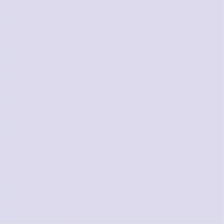

In [19]:
ToPILImage()(outp[0])

In [20]:
trainer.predict(module, datamodule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MisconfigurationException: ignored